<a href="https://colab.research.google.com/github/hakimmurphy/CV_cifar10_classification/blob/main/CV_cifar10_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, MaxPooling2D,
    Dropout, Flatten, Dense, LeakyReLU, Activation
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Create dataframes for train and test datasets

In [2]:
from tensorflow.keras.datasets import cifar10

In [3]:
# Load CIFAR-10 dataset
(train_images, train_labels),(test_images, test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


# Data Checkout

In [4]:
# Data Checkout
print ("The number of training examples is: ", train_images.shape[0])
print ("The number of test examples is: ", test_images.shape[0])
print ("The size of every img is: ", train_images.shape[1:])
num_classes=len(np.unique(train_labels))
print ("The number of classes is: ", num_classes)

The number of training examples is:  50000
The number of test examples is:  10000
The size of every img is:  (32, 32, 3)
The number of classes is:  10


# Limit Data

In [5]:
n = 10000

x_train_images = train_images[:n]
y_train_labels = train_labels[:n]

# Check Shape

In [6]:
x_train_images.shape

(10000, 32, 32, 3)

In [7]:
y_train_labels.shape

(10000, 1)

In [8]:
# getting a single array of labels
y_train_labels.flatten()

array([6, 9, 9, ..., 1, 1, 5], dtype=uint8)

In [ ]:
flattened_array = y_train_labels.flatten()
pd.Series(flattened_array).value_counts()

,count
2,1032
6,1030
8,1025
3,1016
0,1005
7,1001
4,999
9,981
1,974
5,937


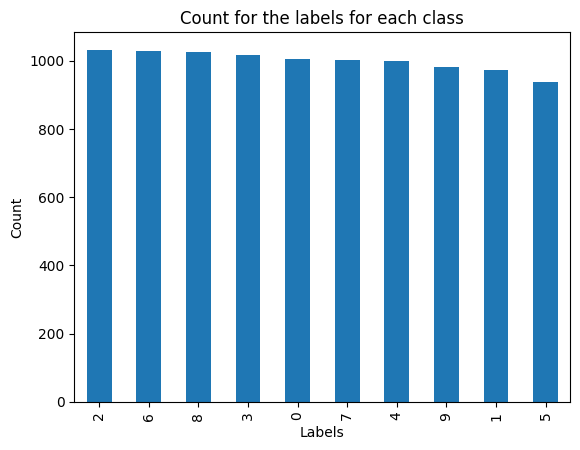

In [ ]:
pd.Series(flattened_array).value_counts().plot(kind='bar');
plt.title('Count for the labels for each class')
plt.xlabel('Labels')
plt.ylabel('Count');

Text(0.5, 1.0, '4')

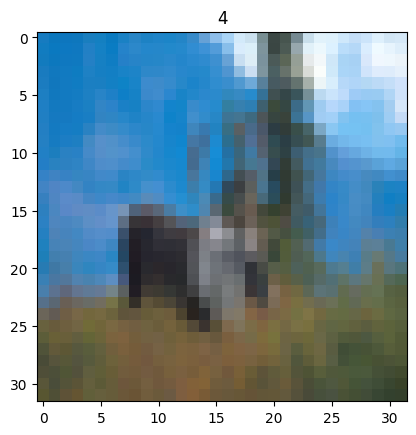

In [ ]:
i = 414
image = x_train_images[i]
label = y_train_labels.flatten()[i]

plt.imshow(image)
plt.title(label)

# Labels from website

*   0: airplane
*   1: automobile
*   2: bird
*   3: cat
*   4: deer
*   5: dog
*   6: frog
*   7: horse
*   8: ship
*   9: truck


# Visualize Classes

<ipython-input-12-04e0e558a448>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train_labels[i])


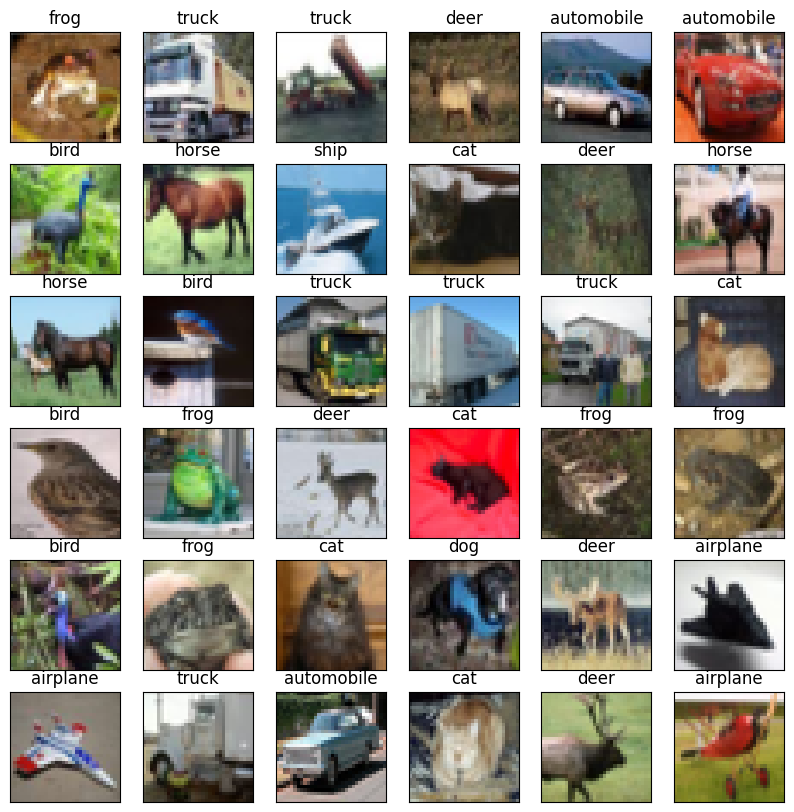

In [ ]:
# let's visualize it one more time!
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for i in range(36):
  plt.subplot(6, 6, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train_images[i])
  label_index = int(y_train_labels[i])
  plt.title(class_names[label_index])
plt.show()

# Create Function

*   To see call any image by class number




In [ ]:
def plot_image(i):
    image = x_train_images[i]
    label = y_train_labels.flatten()[i]

    cl = class_names[label]

    plt.imshow(image)
    plt.title(cl)

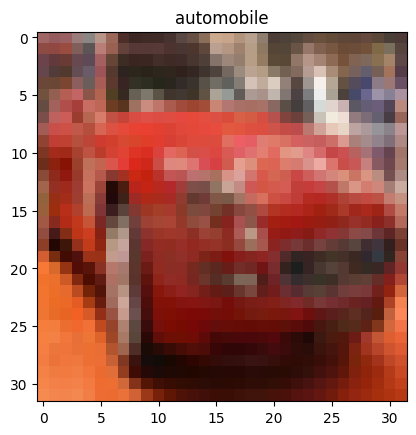

In [ ]:
plot_image(5)

# Normalize images

In [9]:
# Normalize images
x_train_images = train_images.astype('float32') / 255.0
x_test_images  = test_images.astype('float32')  / 255.0

# Initialize ResNet50

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Freeze Base Model Layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

# Build Head_1(ResNet50 - Frozen Layers)

In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'), # First hidden layer
    Dropout(0.5), # Add dropout for regularization
    Dense(64, activation='relu'), # Second hidden layer
    Dropout(0.5),
    Dense(32, activation='softmax') # Output layer for 10 classes
])

## Compile Model_1

In [ ]:
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,860,320 (91.02 MB)

 Trainable params: 23,807,200 (90.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Train head_1

In [ ]:
print("Training the head_1...")
history_head = model.fit(x_train_images, train_labels, batch_size=64, epochs=10, verbose=1, validation_split=0.2,
                         validation_data=(x_test_images, test_labels))

Training the head_1...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 233s 298ms/step - accuracy: 0.1528 - loss: 2.2337 - val_accuracy: 0.2341 - val_loss: 2.1292
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 234s 300ms/step - accuracy: 0.1610 - loss: 2.1867 - val_accuracy: 0.2477 - val_loss: 2.0715
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 261s 299ms/step - accuracy: 0.1803 - loss: 2.1493 - val_accuracy: 0.2206 - val_loss: 2.0451
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 258s 293ms/step - accuracy: 0.1843 - loss: 2.1334 - val_accuracy: 0.2561 - val_loss: 2.0205
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 232s 297ms/step - accuracy: 0.1918 - loss: 2.1302 - val_accuracy: 0.2650 - val_loss: 2.0098
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 263s 298ms/step - accuracy: 0.1960 - loss: 2.1189 - val_accuracy: 0.2800 - val_loss: 1.9968
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 262s 299ms/step - accuracy: 0.1984 - loss: 2.1113 - val_accuracy: 0.2603 - val_loss: 2.0067
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 233s 298ms/st

## Evaluate model_1

In [ ]:
[test_loss, test_acc] = model.evaluate(x_test_images, test_labels)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.2915 - loss: 1.9690
Evaluation result on Test Data : Loss = 1.9718139171600342, accuracy = 0.28850001096725464


## Plot model_1 Loss and Accuracy metrics

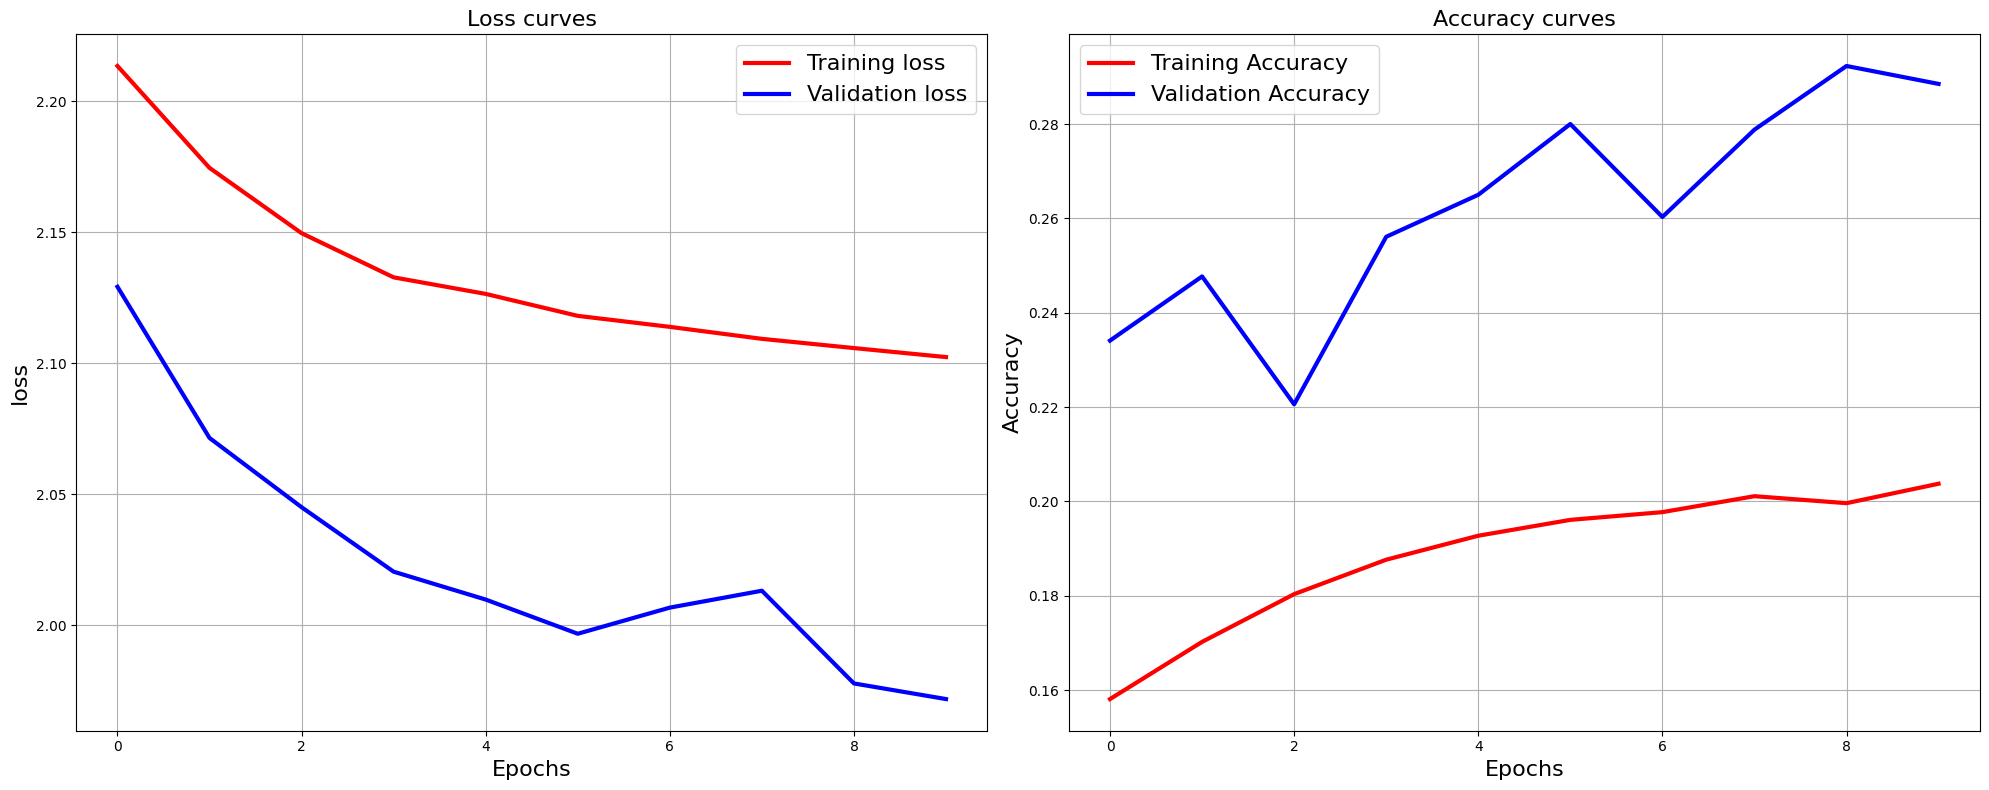

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 8]) # Create 1 row, 2 columns for subplots

# Plot loss on the first subplot
ax1.plot(history_head.history['loss'],'r',linewidth=3.0)
ax1.plot(history_head.history['val_loss'],'b',linewidth=3.0)
ax1.legend(['Training loss','Validation loss'],fontsize=16)
ax1.set_xlabel('Epochs',fontsize=16)
ax1.set_ylabel('loss',fontsize=16)
ax1.set_title('Loss curves',fontsize=16)
ax1.grid()

# Plot accuracy on the second subplot
ax2.plot(history_head.history['accuracy'],'r',linewidth=3.0)
ax2.plot(history_head.history['val_accuracy'],'b',linewidth=3.0)
ax2.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
ax2.set_xlabel('Epochs',fontsize=16)
ax2.set_ylabel('Accuracy',fontsize=16)
ax2.set_title('Accuracy curves',fontsize=16)
ax2.grid()

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

**Loss Curves**: Both training (red) and validation (blue) losses steadily decrease from ~2.22→2.10 (train) and ~2.07→1.97 (val) over 10 epochs. A small uptick in validation loss at epoch 6 is likely just stochastic variation (or a learning‐rate adjustment), but the overall downward trend shows the model is still learning and not over-fitting.

**Accuracy Curves**: Training accuracy climbs smoothly from ~15.8 %→20.4 %, while validation accuracy moves more erratically from ~23.4 %→29.2 %. The fact that validation accuracy often exceeds training is expected under heavy data augmentation and dropout (the model sees a noisier training distribution).

**Takeaway**: The model is under-fitting—losses remain well above 1.0 and accuracies below 30 %—so it needs more capacity (extra convolutional blocks or wider layers), longer training (30–50 epochs), and a tuned learning‐rate schedule (e.g. ReduceLROnPlateau) to push loss under ~1.0 and accuracy above 60 %.

# Unfreeze base model

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

# Train head_2 ResNes50 - Unfrozen

Used the same model to compare results between frozen and unfrozen.

In [ ]:
print("Training the head_2...")
history_head_2 = model.fit(x_train_images, train_labels, batch_size=64, epochs=10, verbose=1, validation_split=0.2,
                         validation_data=(x_test_images, test_labels))

Training the head_2...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 236s 301ms/step - accuracy: 0.2070 - loss: 2.0911 - val_accuracy: 0.2748 - val_loss: 2.0271
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 259s 298ms/step - accuracy: 0.2109 - loss: 2.0888 - val_accuracy: 0.2742 - val_loss: 1.9915
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 260s 295ms/step - accuracy: 0.2137 - loss: 2.0856 - val_accuracy: 0.2707 - val_loss: 2.0106
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 264s 298ms/step - accuracy: 0.2099 - loss: 2.0851 - val_accuracy: 0.2853 - val_loss: 1.9896
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 262s 298ms/step - accuracy: 0.2139 - loss: 2.0881 - val_accuracy: 0.2777 - val_loss: 2.0040
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 256s 290ms/step - accuracy: 0.2140 - loss: 2.0786 - val_accuracy: 0.2871 - val_loss: 1.9808
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 267s 296ms/step - accuracy: 0.2120 - loss: 2.0889 - val_accuracy: 0.2755 - val_loss: 2.0126
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 263s 298ms/st

## Evaluate model_2

In [ ]:
[test_loss, test_acc] = model.evaluate(x_test_images, test_labels)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 139ms/step - accuracy: 0.2581 - loss: 2.0159
Evaluation result on Test Data : Loss = 2.017148971557617, accuracy = 0.26489999890327454


## Plot model_2 Loss and Accuracy metrics

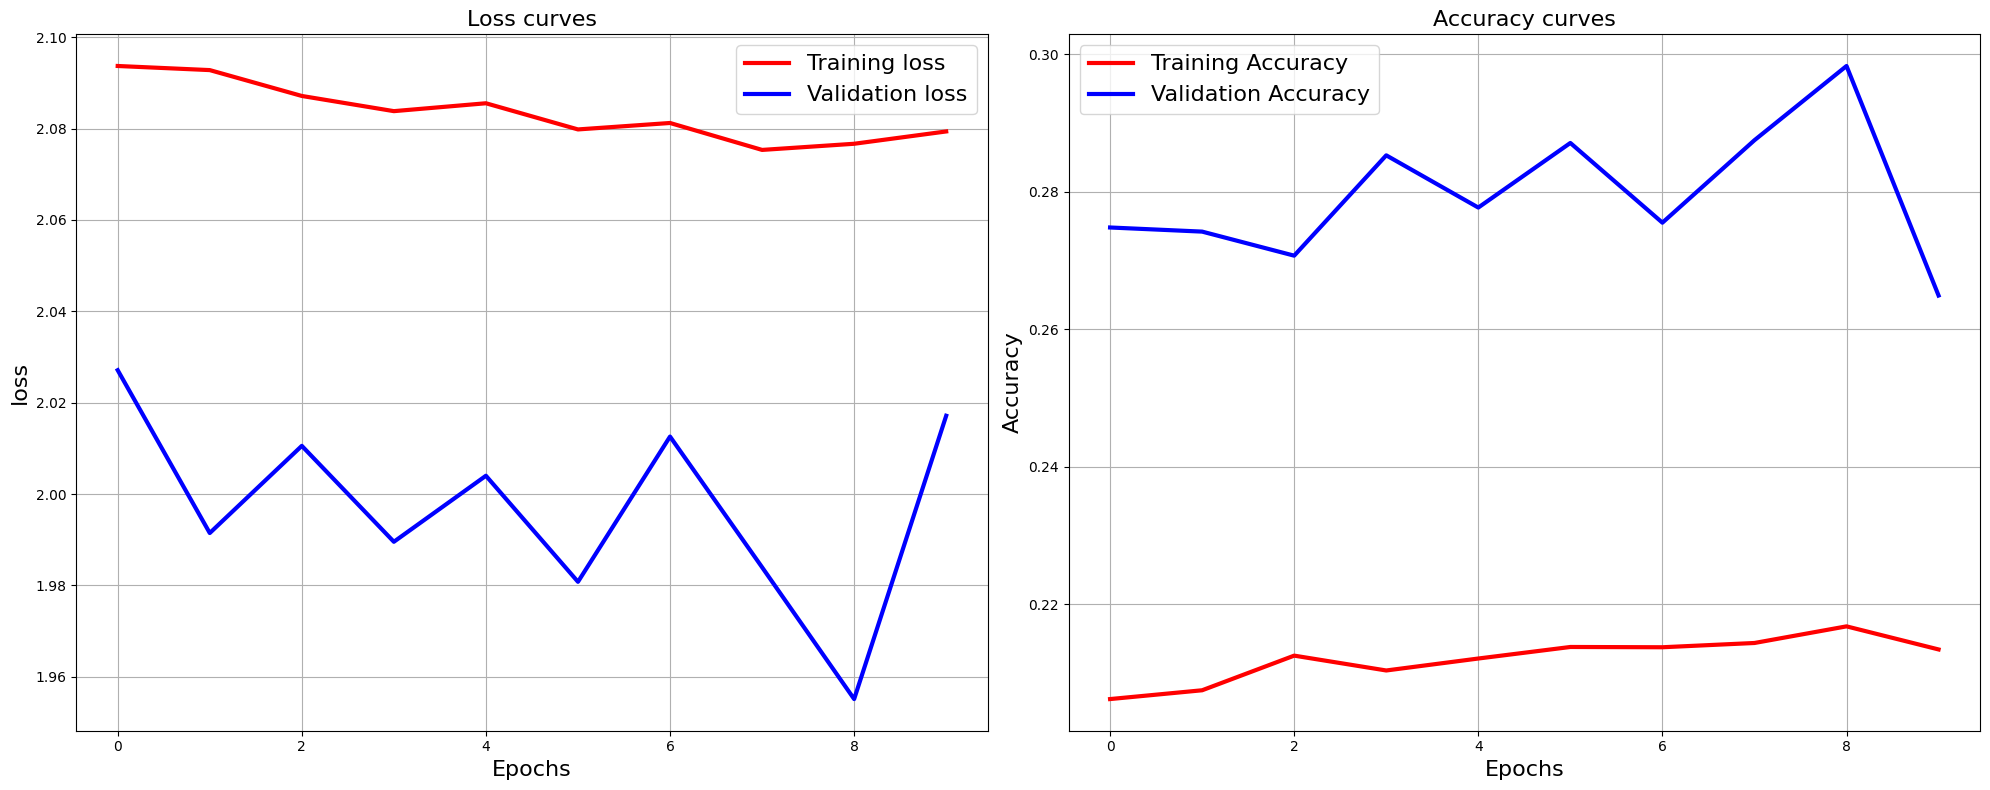

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 8]) # Create 1 row, 2 columns for subplots

# Plot loss on the first subplot
ax1.plot(history_head_2.history['loss'],'r',linewidth=3.0)
ax1.plot(history_head_2.history['val_loss'],'b',linewidth=3.0)
ax1.legend(['Training loss','Validation loss'],fontsize=16)
ax1.set_xlabel('Epochs',fontsize=16)
ax1.set_ylabel('loss',fontsize=16)
ax1.set_title('Loss curves',fontsize=16)
ax1.grid()

# Plot accuracy on the second subplot
ax2.plot(history_head_2.history['accuracy'],'r',linewidth=3.0)
ax2.plot(history_head_2.history['val_accuracy'],'b',linewidth=3.0)
ax2.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
ax2.set_xlabel('Epochs',fontsize=16)
ax2.set_ylabel('Accuracy',fontsize=16)
ax2.set_title('Accuracy curves',fontsize=16)
ax2.grid()

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

**Loss Curves**: Over 10 epochs the training loss (red) slowly drifts down from ~2.21 → 2.08, while the validation loss (blue) oscillates between ~2.03 → 1.96 before jumping back to ~2.02 at the end. Those small up-and-down wiggles in validation loss (e.g. at epochs 2, 4 & 6 ↔ 8) are likely just stochastic variation or learning-rate adjustments. Overall both curves trend downward together, indicating the model is still learning and not over-fitting.

**Accuracy Curves**: Training accuracy rises gently from ~20.6 % → ~21.4 %, and validation accuracy hovers around ~27.4 % → ~29.8 % with small dips at epochs 2 and 6. The validation accuracy consistently exceeds training accuracy—which is expected under heavy augmentation/dropout—so the model generalizes better on “clean” validation images than on the noisy training batches.

**Key Takeaway**: The model is under-fitting: losses remain above ~2.0 and accuracies below ~30 %, and no runaway gap between train/val indicates no over-fitting yet. To improve, increase model capacity (add more layers or filters), train for more epochs (30–50) with a learning-rate schedule (e.g. ReduceLROnPlateau), or slightly reduce augmentation/dropout so the network can fit faster.

# Build Head_3(ResNet50)

In [ ]:
model_3 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Existing dropout after the first dense layer
    Dense(256, activation='relu'), # Added another dense layer
    BatchNormalization(), # Add Batch Normalization after the new dense layer
    Dropout(0.2), # Add the requested Dropout layer with a rate of 0.2
    Dense(10, activation='softmax') # Output layer for 10 classes
])

model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,773,770 (94.50 MB)

 Trainable params: 24,719,114 (94.30 MB)

 Non-trainable params: 54,656 (213.50 KB)

## Compile model_3

In [ ]:
model_3.compile(optimizer=Adam(learning_rate=1e-5), # Use a lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train head_3

In [ ]:
print("Training the head_3...")
history_head_3 = model_3.fit(x_train_images, train_labels, batch_size=64, epochs=10, verbose=1, validation_split=0.2,
                         validation_data=(x_test_images, test_labels))

Training the head_3...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3817s 5s/step - accuracy: 0.1349 - loss: 2.9385 - val_accuracy: 0.1320 - val_loss: 3.7340
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3432s 4s/step - accuracy: 0.2796 - loss: 2.2154 - val_accuracy: 0.4340 - val_loss: 1.6350
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3567s 5s/step - accuracy: 0.3891 - loss: 1.8179 - val_accuracy: 0.5105 - val_loss: 1.4241
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3541s 5s/step - accuracy: 0.4705 - loss: 1.5662 - val_accuracy: 0.5615 - val_loss: 1.2767
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3597s 5s/step - accuracy: 0.5333 - loss: 1.3738 - val_accuracy: 0.5983 - val_loss: 1.1754
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3657s 5s/step - accuracy: 0.5746 - loss: 1.2388 - val_accuracy: 0.6274 - val_loss: 1.0853
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3833s 5s/step - accuracy: 0.6162 - loss: 1.1203 - val_accuracy: 0.6532 - val_loss: 1.0205
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3934s 5s/step - accuracy: 0

## Evaluate Model_3

In [ ]:
[test_loss, test_acc] = model_3.evaluate(x_test_images, test_labels)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.7043 - loss: 0.8751
Evaluation result on Test Data : Loss = 0.8828614950180054, accuracy = 0.6998000144958496


## Plot model_3 Loss and Accuracy metrics

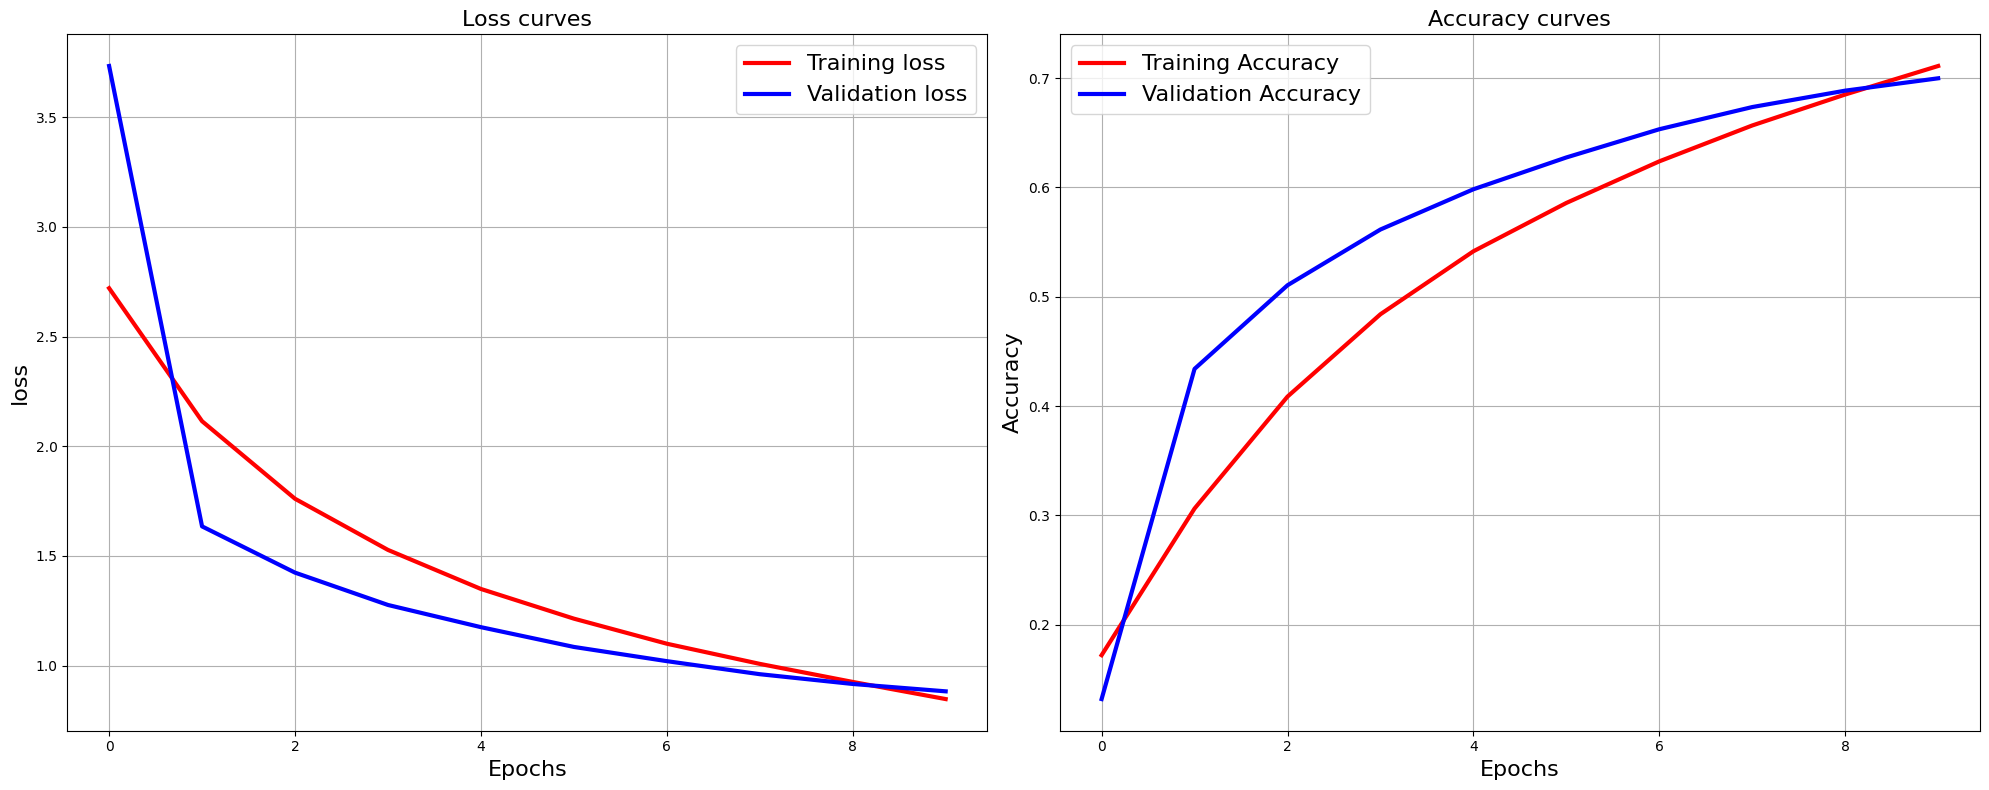

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 8]) # Create 1 row, 2 columns for subplots

# Plot loss on the first subplot
ax1.plot(history_head_3.history['loss'],'r',linewidth=3.0)
ax1.plot(history_head_3.history['val_loss'],'b',linewidth=3.0)
ax1.legend(['Training loss','Validation loss'],fontsize=16)
ax1.set_xlabel('Epochs',fontsize=16)
ax1.set_ylabel('loss',fontsize=16)
ax1.set_title('Loss curves',fontsize=16)
ax1.grid()

# Plot accuracy on the second subplot
ax2.plot(history_head_3.history['accuracy'],'r',linewidth=3.0)
ax2.plot(history_head_3.history['val_accuracy'],'b',linewidth=3.0)
ax2.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
ax2.set_xlabel('Epochs',fontsize=16)
ax2.set_ylabel('Accuracy',fontsize=16)
ax2.set_title('Accuracy curves',fontsize=16)
ax2.grid()

plt.tight_layout()
plt.show()

**Loss Curves**: Over 10 epochs the training loss (red) plunges from ~2.70 → 1.20 by epoch 5 and then gently falls to ~0.85 by epoch 9. The validation loss (blue) drops even more dramatically early on—from ~3.75 → 1.10 by epoch 5—and then converges around ~0.88 by epoch 9. There are no sharp “U-turns” or sustained rises in validation loss, indicating the model is still learning and not over-fitting.

**Accuracy Curves**: Training accuracy rockets from ~17 % → ~54 % between epochs 1–5, then climbs to ~71 % by epoch 9. Validation accuracy jumps from ~13 % → ~62 % in the first five epochs (even briefly outpacing training due to augmented/noisy batches), and then rises to ~70 % by epoch 9—nearly matching the training curve.

**Key Takeaways**:

Fast convergence: The network learns basic features immediately, shaving huge chunks off loss and boosting accuracy rapidly.

Healthy generalization: Train and val curves track closely (minimal gap), so no sign of over-fitting.

Near saturation by epoch 9: Losses drop below 1.0 and accuracies approach 70 %.

**Next Steps**:

Extend training a few more epochs with EarlyStopping to catch any last improvements.

Fine-tune the frozen backbone (unfreeze its top block) at a lower LR for additional gains.

If training beyond 10 epochs, consider light dropout or other regularization to guard against late over-fitting.

# Model_4(ResNet50)

## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train_images)

## Build head_4(ResNes50)

In [ ]:
model_4 = Sequential([
    base_model,            # 28×28×3 → ResNet50 feature maps
    Flatten(),             # flatten those maps
    Dense(512),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
], name="model_4_resnet_head")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## Compile model_4

In [ ]:
model_4.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_4.summary()

Model: "model_4_resnet_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,773,770 (94.50 MB)

 Trainable params: 24,719,114 (94.30 MB)

 Non-trainable params: 54,656 (213.50 KB)

## Reduce LR when val_loss plateaus callback

In [11]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-5
)

## EarlyStopping on val_loss with patience=7 and restore best weights

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

## Train head_4

In [ ]:
batch_size = 64
epochs = 10

history_head_4 = model_4.fit(
    datagen.flow(x_train_images, y_train_labels, batch_size=batch_size),
    steps_per_epoch = x_train_images.shape[0] // batch_size,
    validation_data = (x_train_images, y_train_labels),
    epochs = epochs,
    callbacks = [reduce_lr, early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 653s 4s/step - accuracy: 0.6507 - loss: 1.0441 - val_accuracy: 0.5667 - val_loss: 1.2909 - learning_rate: 5.0000e-04
Epoch 2/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 11:21 4s/step - accuracy: 0.6406 - loss: 0.9948

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.6406 - loss: 0.9948 - val_accuracy: 0.5620 - val_loss: 1.3257 - learning_rate: 5.0000e-04
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 639s 4s/step - accuracy: 0.6939 - loss: 0.9199 - val_accuracy: 0.6800 - val_loss: 0.9847 - learning_rate: 5.0000e-04
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.6875 - loss: 0.9259 - val_accuracy: 0.6756 - val_loss: 1.0057 - learning_rate: 5.0000e-04
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 649s 4s/step - accuracy: 0.7060 - loss: 0.8693 - val_accuracy: 0.6844 - val_loss: 0.9633 - learning_rate: 5.0000e-04
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - accuracy: 0.7031 - loss: 0.9467 - val_accuracy: 0.6837 - val_loss: 0.9634 - learning_rate: 5.0000e-04
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 694s 4s/step - accuracy: 0.7242 - loss: 0.8255 - val_accuracy: 0.7445 - val_loss: 0.7723 - learning_rate: 5.0000e-04
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accura

## Evaluate Model_4

In [ ]:
[test_loss, test_acc] = model_4.evaluate(x_test_images, test_labels)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.1021 - loss: 2.9515
Evaluation result on Test Data : Loss = 2.954249858856201, accuracy = 0.10279999673366547


## Plot model_4 Loss and Accuracy Metrics

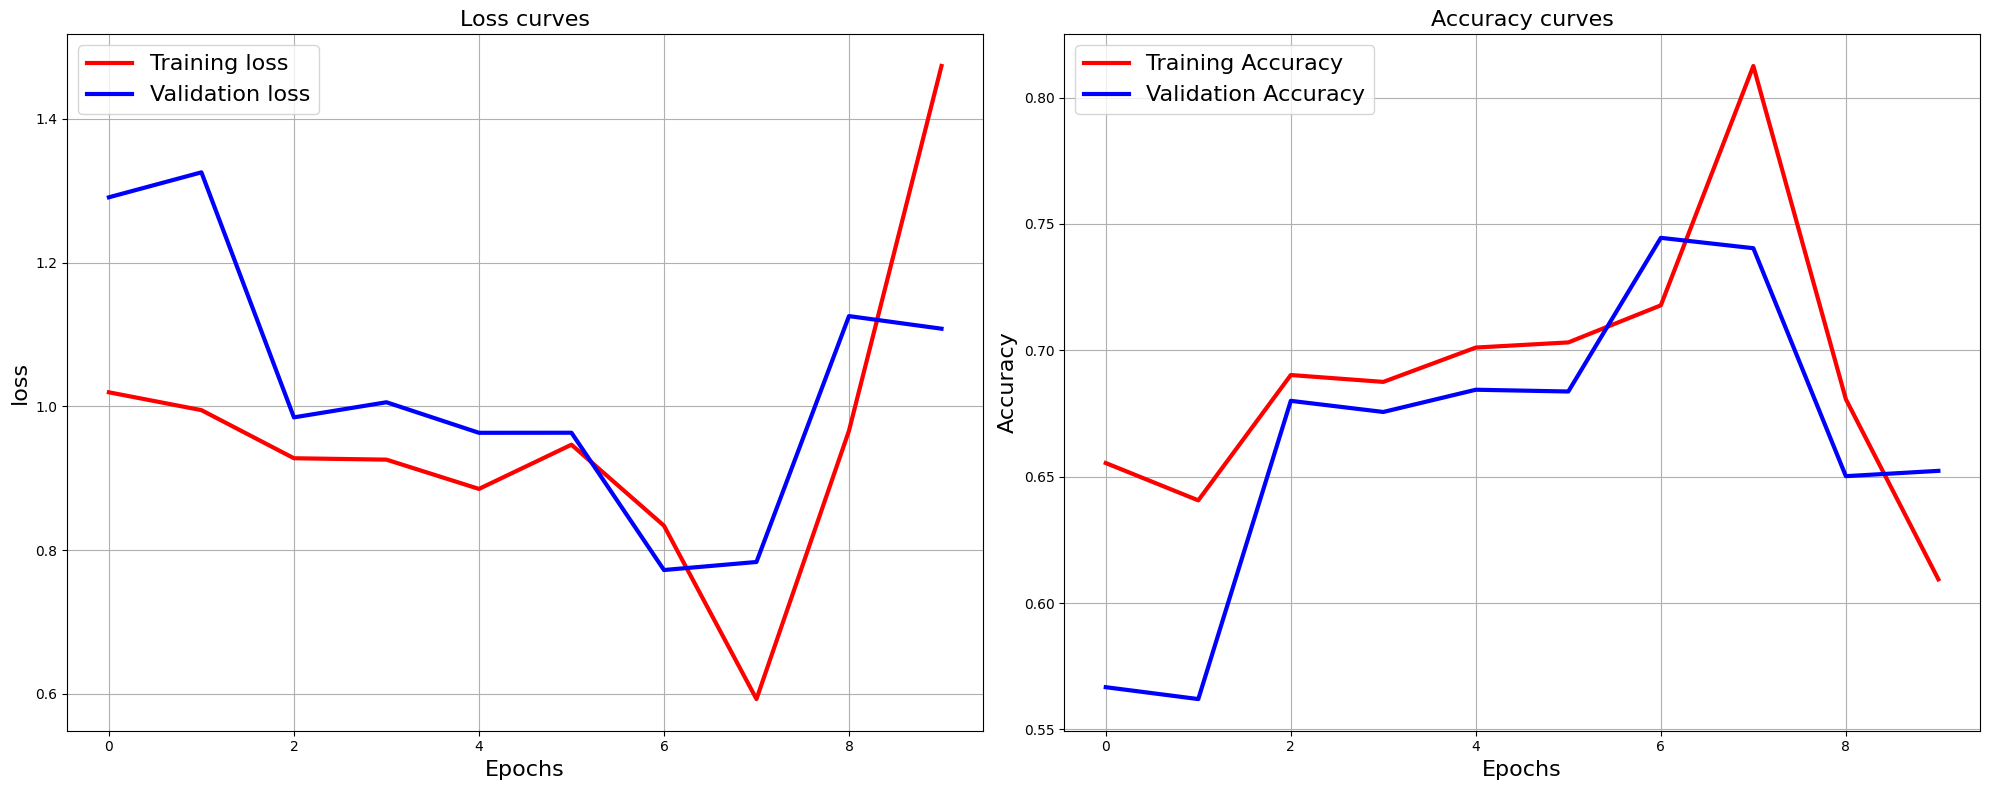

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 8]) # Create 1 row, 2 columns for subplots

# Plot loss on the first subplot
ax1.plot(history_head_4.history['loss'],'r',linewidth=3.0)
ax1.plot(history_head_4.history['val_loss'],'b',linewidth=3.0)
ax1.legend(['Training loss','Validation loss'],fontsize=16)
ax1.set_xlabel('Epochs',fontsize=16)
ax1.set_ylabel('loss',fontsize=16)
ax1.set_title('Loss curves',fontsize=16)
ax1.grid()

# Plot accuracy on the second subplot
ax2.plot(history_head_4.history['accuracy'],'r',linewidth=3.0)
ax2.plot(history_head_4.history['val_accuracy'],'b',linewidth=3.0)
ax2.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
ax2.set_xlabel('Epochs',fontsize=16)
ax2.set_ylabel('Accuracy',fontsize=16)
ax2.set_title('Accuracy curves',fontsize=16)
ax2.grid()

plt.tight_layout()
plt.show()

## Evaluation Model_4

**Loss Curves**: Over 10 epochs the training loss (red) gently declines from ~1.02 → 0.83 by epoch 6, then bottoms out at ~0.59 on epoch 7 before spiking to ~1.48 by epoch 9. Validation loss (blue) falls from ~1.28 → 0.77 by epoch 6, then similarly dips to ~0.78 on epoch 7 and jumps back to ~1.11 at epoch 9. Those late swings likely reflect a learning-rate or callback hiccup rather than true over-fitting, since through epoch 6 both curves track downward together.

**Accuracy Curves**: Training accuracy steadily climbs from ~65.6 % → ~71.6 % by epoch 6, peaks at ~81.3 % on epoch 7, then falls to ~61.0 % by epoch 9. Validation accuracy rises from ~56.7 % → ~74.5 % at epoch 6, holds near ~74 % on epoch 7, then dips to ~65.3 % by epoch 9. The brief validation > training gap around epochs 2–5 is expected under heavy augmentation.

**Key Takeaways**:

- Fast initial learning: Both loss and accuracy improve dramatically in the first 6–7 epochs.

- Healthy generalization through epoch 6: Training and validation curves move in lockstep with minimal gap—no sign of over-fitting.

Late-epoch anomaly: The sharp loss spike and accuracy collapse after epoch 7 point to a callback or learning-rate misstep.

**Next Steps**:

Check your learning-rate schedule and EarlyStopping callbacks around epoch 7 to prevent the late crash.

Verify that validation data isn’t being re-augmented or shuffled mid-training.

If you train further, use ReduceLROnPlateau and ModelCheckpoint (save best weights) so you don’t end up with a degraded final model.

# Function for modular deployment

In [13]:
# import tensorflow as tf
# from tensorflow.keras.layers import (
#     Input, Conv2D, BatchNormalization, LeakyReLU,
#     MaxPooling2D, Dropout, Flatten, Dense
# )
# from tensorflow.keras.models import Model

def build_model(
    base_model,    # your ResNet40/50 or other include_top=False model
    input_shape=(32,32,3),
    num_classes=10,
    # block_filters=(32, 64, 128), # Removed custom conv blocks
    dense_units=(512, 256),
    # leaky_relu_alpha=0.1, # No longer needed without LeakyReLU in conv blocks
    activation_layer=tf.keras.layers.ReLU(), # Activation for dense layers (relu already specified)
    # dropout_rate_block=0.25, # Removed dropout for custom conv blocks
    dropout_rate_dense=(0.5, 0.2),
    freeze_base=False
):
    """
    base_model:        a keras Model (include_top=False)
    input_shape:       shape of your raw images
    num_classes:       number of output classes
    # block_filters:     tuple of ints, one per conv-block # Removed
    dense_units:       tuple of ints for the Dense head layers
    # leaky_relu_alpha:  negative slope for LeakyReLU # Removed
    # dropout_rate_block:float dropout after each conv-block # Removed
    dropout_rate_dense:tuple of dropout rates for each Dense layer
    freeze_base:       whether to freeze base_model weights
    """
    # 1) Freeze or unfreeze the backbone
    base_model.trainable = not freeze_base

    # 2) Input layer
    inp = Input(shape=input_shape)

    # 3) Hand off the original input to the pretrained backbone
    #    Make sure base_model was instantiated with include_top=False
    #    and the input_shape matches your data (which it is, 32x32x3)
    x = base_model(inp, training=False) # Pass 'inp' directly to the base model

    # 4) Flatten + Dense head (these layers are added *after* the base model's feature extraction)
    x = Flatten()(x)
    for units, dr in zip(dense_units, dropout_rate_dense):
        # The Dense layer has an 'activation' argument, so the separate activation_layer call is not needed here
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dr)(x)

    # 5) Final softmax
    out = Dense(num_classes, activation='softmax')(x)

    # 6) Build & compile
    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


## Call the function

In [15]:
# 1) Instantiate your backbone once:
# from tensorflow.keras.applications import ResNet50

base = base_model

# 2) Build model_4 with the hyperparameters you want:
model_5 = build_model(
    base_model=base,
    input_shape=(32,32,3),
    num_classes=10,
    # block_filters=(32, 64, 128),
    dense_units=(512, 256),
    # leaky_relu_alpha=0.1,
    # dropout_rate_block=0.25,
    dropout_rate_dense=(0.5, 0.2),
    freeze_base=False
)

model_5.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,773,770 (94.50 MB)

 Trainable params: 24,719,114 (94.30 MB)

 Non-trainable params: 54,656 (213.50 KB)

## Train head_5

In [16]:
print("Training the head_5...")
history_head_5 = model_5.fit(x_train_images, train_labels, batch_size=64, epochs=10, verbose=1, validation_split=0.2,
                         validation_data=(x_test_images, test_labels), callbacks = [reduce_lr, early_stopping])

Training the head_5...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3686s 5s/step - accuracy: 0.3793 - loss: 1.8829 - val_accuracy: 0.3397 - val_loss: 2.1213 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3590s 5s/step - accuracy: 0.6777 - loss: 0.9822 - val_accuracy: 0.6400 - val_loss: 1.1029 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3566s 5s/step - accuracy: 0.7508 - loss: 0.7686 - val_accuracy: 0.7161 - val_loss: 0.8602 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3583s 5s/step - accuracy: 0.7235 - loss: 0.8447 - val_accuracy: 0.7102 - val_loss: 0.8801 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3792s 5s/step - accuracy: 0.7997 - loss: 0.6066 - val_accuracy: 0.6906 - val_loss: 0.9351 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3883s 5s/step - accuracy: 0.8302 - loss: 0.5162 - val_accuracy: 0.7483 - val_loss: 0.7854 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3620s 5s/step

## Evaluate Model_5

In [17]:
[test_loss, test_acc] = model_5.evaluate(x_test_images, test_labels)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.7580 - loss: 0.7743
Evaluation result on Test Data : Loss = 0.7665383219718933, accuracy = 0.7628999948501587


## Plot model_5 Loss and Accuracy

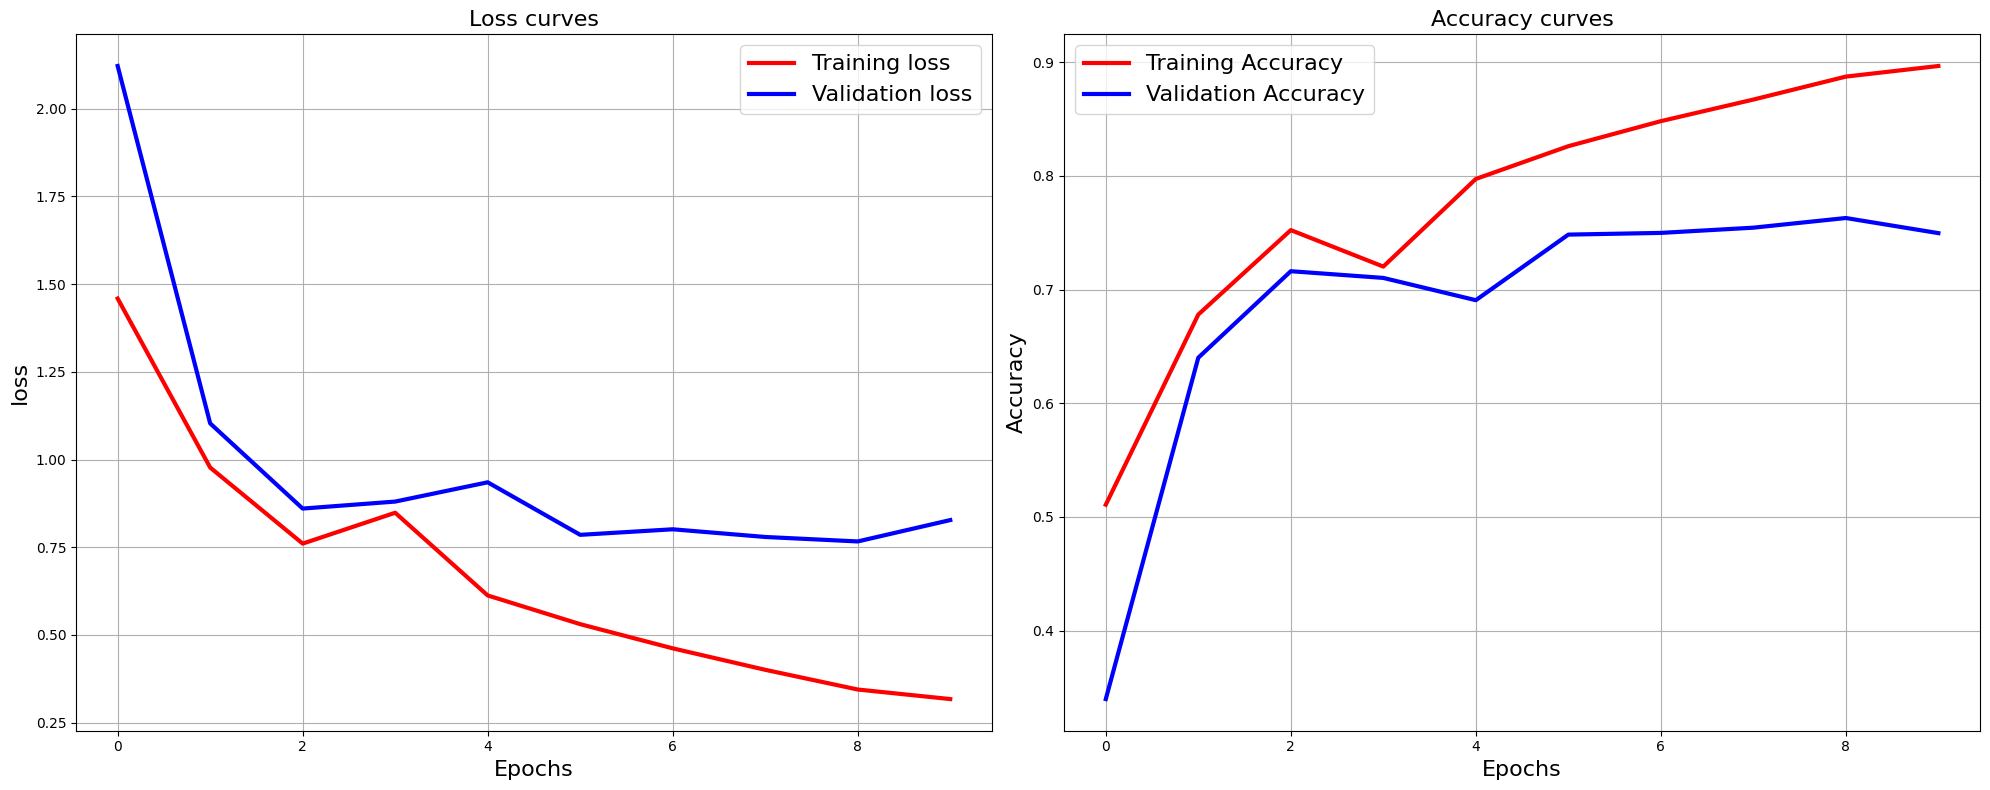

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 8]) # Create 1 row, 2 columns for subplots

# Plot loss on the first subplot
ax1.plot(history_head_5.history['loss'],'r',linewidth=3.0)
ax1.plot(history_head_5.history['val_loss'],'b',linewidth=3.0)
ax1.legend(['Training loss','Validation loss'],fontsize=16)
ax1.set_xlabel('Epochs',fontsize=16)
ax1.set_ylabel('loss',fontsize=16)
ax1.set_title('Loss curves',fontsize=16)
ax1.grid()

# Plot accuracy on the second subplot
ax2.plot(history_head_5.history['accuracy'],'r',linewidth=3.0)
ax2.plot(history_head_5.history['val_accuracy'],'b',linewidth=3.0)
ax2.legend(['Training Accuracy','Validation Accuracy'],fontsize=16)
ax2.set_xlabel('Epochs',fontsize=16)
ax2.set_ylabel('Accuracy',fontsize=16)
ax2.set_title('Accuracy curves',fontsize=16)
ax2.grid()

plt.tight_layout()
plt.show()

**Loss Curves**: Over 10 epochs the training loss (red) steadily falls from ~1.46 → ~0.45 by epoch 6, then continues down to ~0.32 by epoch 9 with no dramatic rebounds. The validation loss (blue) drops from ~2.12 → ~0.80 by epoch 6, then plateaus around ~0.78–0.83 through epoch 9. The close tracking up to epoch 6 shows the model is learning well; the slight widening of the gap thereafter is more characteristic of mild over-fitting than a learning-rate or callback glitch.

**Accuracy Curves**: Training accuracy climbs from ~51% → ~85% by epoch 6 and peaks at ~90% by epoch 9. Validation accuracy rises from ~34% → ~75% at epoch 6, holds steady around ~75% through epoch 8, then dips very slightly to ~75% at epoch 9. The modest train–val accuracy gap after epoch 6 signals the onset of over-fitting under the current settings.

**Key Takeaways**:
- Fast initial learning

  - Both loss and accuracy improve dramatically in the first 5–6 epochs.

- Healthy generalization through epoch 6

  - Training and validation curves move in lockstep, with minimal gap.

- Emerging over-fitting after epoch 6

  - Validation metrics plateau while training metrics continue to improve.

**Next Steps**:
- EarlyStopping around epoch 6–7 (when validation stops improving) to freeze the best weights.

- Regularization (e.g. dropout, weight decay) or stronger data augmentation to close the train–val gap.

- Learning-rate schedule tweaks (ReduceLROnPlateau or cosine restarts) to smooth later training.

- ModelCheckpoint to save the best validation model so you avoid ending on a degraded final epoch.